In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [13]:
def compute_mvc(p, cage):
    n = len(cage)
    w = np.zeros(n)
    eps = 1e-10

    for i in range(n):
        vi = cage[i] - p
        vip1 = cage[(i + 1) % n] - p

        len_vi = np.linalg.norm(vi)
        len_vip1 = np.linalg.norm(vip1)

        if len_vi < eps or len_vip1 < eps:
            # p is on a cage vertex
            w[i] = 1
            return w

        theta = np.arccos(
            np.clip(np.dot(vi, vip1) / (len_vi * len_vip1), -1.0, 1.0)
        )
        tan_half_theta = np.tan(theta / 2.0)
        w[i] += (tan_half_theta / len_vi)
        w[(i + 1) % n] += (tan_half_theta / len_vip1)

    w_sum = np.sum(w)
    return w / w_sum

def warp_image(image, cage, deformed_cage):
    h, w = image.shape[:2]
    warped_image = np.zeros_like(image)

    for y in range(h):
        for x in range(w):
            p = np.array([x, y], dtype=np.float32)
            if cv2.pointPolygonTest(deformed_cage, (x, y), measureDist=False) >= 0:
                # Step 1: Compute MVC wrt the DEFORMED cage
                weights = compute_mvc(p, deformed_cage)
                
                # Step 2: Use same weights to find the ORIGINAL position
                orig_p = np.sum(weights[:, None] * cage, axis=0)
                src_x, src_y = orig_p.astype(int)

                # Step 3: Sample the original image
                if 0 <= src_x < w and 0 <= src_y < h:
                    warped_image[y, x] = image[src_y, src_x]  # Note: image[y, x] == image[row, col]
    return warped_image



In [14]:
import cv2
import numpy as np

def generate_test_image(width=400, height=400):
    # Create a blank white RGB image
    image = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Draw a filled blue rectangle
    cv2.rectangle(image, (100, 100), (300, 300), (255, 0, 0), -1)

    # Add some text
    cv2.putText(image, 'MVC', (140, 220), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)

    return image


In [15]:
def draw_cage(image, cage_points, color=(0, 255, 0), thickness=2):
    img_copy = image.copy()
    n = len(cage_points)
    for i in range(n):
        pt1 = tuple(cage_points[i].astype(int))
        pt2 = tuple(cage_points[(i + 1) % n].astype(int))
        cv2.line(img_copy, pt1, pt2, color, thickness)
        cv2.circle(img_copy, pt1, 4, color, -1)
    return img_copy


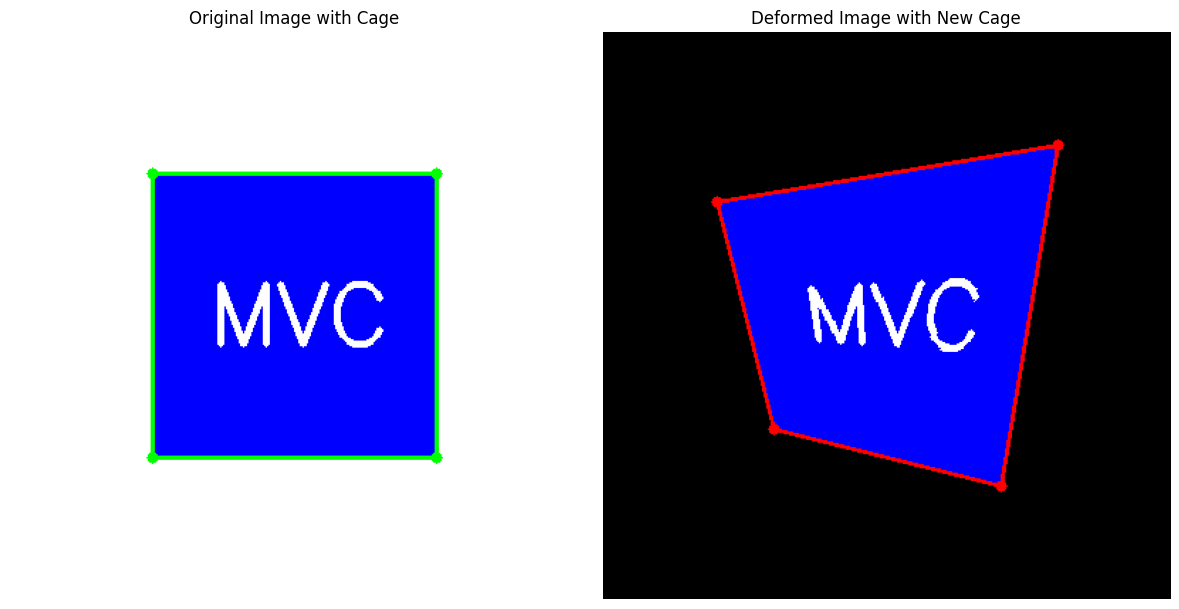

In [16]:
# 1. Generate test image
image = generate_test_image()

# 2. Define cages
cage = np.array([
    [100, 100],
    [300, 100],
    [300, 300],
    [100, 300]
], dtype=np.float32)

deformed_cage = np.array([
    [80, 120],
    [320, 80],
    [280, 320],
    [120, 280]
], dtype=np.float32)

# 3. Warp the image
warped_image = warp_image(image, cage, deformed_cage)

# 4. Draw cages
image_with_cage = draw_cage(image, cage, color=(0, 255, 0))              # green
warped_with_deformed_cage = draw_cage(warped_image, deformed_cage, color=(0, 0, 255))  # red

# 5. Display using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_with_cage, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Cage")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_with_deformed_cage, cv2.COLOR_BGR2RGB))
plt.title("Deformed Image with New Cage")
plt.axis("off")

plt.tight_layout()
plt.show()
